In [1]:
import os
import sys
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")

DataTransformerRegistry.enable('vegafusion')

In [2]:
sys.path.append("../../src")

In [3]:
import main

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp[temp['data_type'] == 'observed']
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [24]:
all_year = temp.columns.values.flatten()

In [6]:
hiwn = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/heat_island_winter_nights.csv')

In [17]:
hiwn.values

array([['2022-11-08 00:00:00+00:00'],
       ['2022-11-08 01:00:00+00:00'],
       ['2022-11-08 02:00:00+00:00'],
       ['2022-11-08 03:00:00+00:00'],
       ['2022-11-08 04:00:00+00:00'],
       ['2022-11-08 05:00:00+00:00'],
       ['2022-11-08 21:00:00+00:00'],
       ['2022-11-08 22:00:00+00:00'],
       ['2022-11-08 23:00:00+00:00'],
       ['2022-11-11 00:00:00+00:00'],
       ['2022-11-11 01:00:00+00:00'],
       ['2022-11-11 02:00:00+00:00'],
       ['2022-11-11 03:00:00+00:00'],
       ['2022-11-11 04:00:00+00:00'],
       ['2022-11-11 05:00:00+00:00'],
       ['2022-12-08 21:00:00+00:00'],
       ['2022-12-08 22:00:00+00:00'],
       ['2022-12-08 23:00:00+00:00'],
       ['2022-12-09 00:00:00+00:00'],
       ['2022-12-28 00:00:00+00:00'],
       ['2023-01-01 21:00:00+00:00'],
       ['2023-01-01 22:00:00+00:00'],
       ['2023-01-01 23:00:00+00:00'],
       ['2023-02-08 00:00:00+00:00'],
       ['2023-02-08 01:00:00+00:00'],
       ['2023-02-08 22:00:00+00:00'],
       ['202

In [7]:
# Define station IDs
stations = ['FRASHA', 'FRBETZ', 'FRBRUH', 'FRDREI', 'FRFRIE', 'FRGART', 'FRGLBA',
            'FRGUNT', 'FRHAID', 'FRHBHF', 'FRHERD', 'FRHOLZ', 'FRIHOC', 'FRINST',
            'FRKART', 'FRLAND', 'FRLORE', 'FRMESS', 'FROWIE', 'FRPDAS', 'FRRIES',
            'FRSEEP', 'FRSTGA', 'FRSTGE', 'FRSTUH', 'FRUNIK', 'FRUWIE', 'FRVAUB',
            'FRWEIN', 'FRWSEE', 'FRZAHR']

# Create a colormap (e.g., using the 'tab20' color palette)
cmap = plt.get_cmap('tab20', len(stations))  # 31 unique colors
station_colors = {station: cmap(i) for i, station in enumerate(stations)}  # Map station to color


In [72]:
def plot(radius, param, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    var = param

    data = vars[[var] + list(time)].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=time, var_name='time', value_name='temperature')

    colors = [lcz_colors[station] for station in data['station_id']]
    plt.scatter(data[var], data['temperature'], marker ='x', c=colors, alpha =0.5)
    plt.xlabel(var,fontsize=16)
    plt.ylabel('Temperature',fontsize=16)
    #ax.set_title(var+' vs Temperature'+' for '+str(radius)+'m radius')

    for i, txt in enumerate(vars.index):
        plt.annotate(txt, (data[var].iloc[i], data['temperature'].iloc[i]), color=lcz_colors[txt])


In [19]:
def stats_multiple_times(radius, var, time):
    vars = gpd.read_parquet(f'/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_{radius}.parquet')
    vars.index = vars['station_id']
    to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF_3D']
    vars = vars.drop(to_remove, axis=1)
    vars = vars.merge(temp, left_on='station_id', right_on='station_id',how='inner')

    scaler = StandardScaler()
    vars_scaled = scaler.fit_transform(vars)
    vars = pd.DataFrame(vars_scaled, columns=vars.columns, index=vars.index)

    data = vars[[var] + list(time)].copy().reset_index()
    data = data.melt(id_vars=[var,'station_id'], value_vars=time, var_name='time', value_name='temperature')
    data = data.dropna()

    # Compute Spearman correlation
    spearman_corr, p_value = spearmanr(data[var], data['temperature'])

    #Pearson and r squared
    pearson_corr, _ = pearsonr(data[var], data['temperature'])
    X = sm.add_constant(data[var])  # Add constant for regression
    model = sm.OLS(data['temperature'], X).fit()
    r_squared = model.rsquared

    # Get the predicted values (fitted values)
    y_pred = model.fittedvalues

    # Calculate the residuals (errors)
    residuals = data['temperature'] - y_pred

    # Calculate the least squares error (RSS)
    rss = np.sum(residuals ** 2)
    # Calculate the Mean Squared Error (MSE)
    mse = rss / len(data[var])
    # Calculate the Root Mean Squared Error (RMSE)
    rmse = np.sqrt(mse)

    # Compute Cook's distance
    influence = model.get_influence()
    cooks_d = influence.cooks_distance[0].max()  # Max Cook's distance

    return data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred

In [44]:
def plot2(ax, radius, var, time):

    data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)

    # Add textbox with correlation and Cook’s distance
    textstr = f"Pearson $r^2$: {r_squared:.3f}\nRMSE: {rmse:.3f}\nSpearman ρ: {spearman_corr:.2f}\nMax Cook's D: {cooks_d:.3f}"
    ax.text(0.55, 0.05, textstr, transform=ax.transAxes, fontsize=12,
            bbox=dict(boxstyle="round,pad=0.3", edgecolor='grey', facecolor='none'))

    #colors = [station_colors[station] for station in data['station_id']]  # Assign colors to each station
    colors = [lcz_colors[station] for station in data['station_id']]  # Assign colors to each station
    ax.scatter(data[var], data['temperature'], marker ='x', c=colors, alpha =0.5)
    ax.plot(data[var], y_pred, color='black', linewidth=1)  # Plot regression
    ax.set_xlabel(var,fontsize=16)
    ax.set_ylabel('Normalised Temperature (K)',fontsize=16)
    #ax.set_title(var+' vs Temperature'+' for '+str(radius)+'m radius')

    for i, txt in enumerate(data['station_id'][:30]):
        ax.annotate(txt, (data[var].iloc[i], data['temperature'].iloc[i]), color=lcz_colors[txt])

In [29]:
# Data as a list of dictionaries
data = [
    {"LCZ": "LCZ 1", "Description": "Compact highrise", "Color": "#910613"},
    {"LCZ": "LCZ 2", "Description": "Compact midrise", "Color": "#D9081C"},
    {"LCZ": "LCZ 3", "Description": "Compact lowrise", "Color": "#FF0A22"},
    {"LCZ": "LCZ 4", "Description": "Open highrise", "Color": "#C54F1E"},
    {"LCZ": "LCZ 5", "Description": "Open midrise", "Color": "#FF6628"},
    {"LCZ": "LCZ 6", "Description": "Open lowrise", "Color": "#FF985E"},
    {"LCZ": "LCZ 7", "Description": "Lightweight low-rise", "Color": "#FDED3F"},
    {"LCZ": "LCZ 8", "Description": "Large lowrise", "Color": "#BBBBBB"},
    {"LCZ": "LCZ 9", "Description": "Sparsely built", "Color": "#FFCBAB"},
    {"LCZ": "LCZ 10", "Description": "Heavy Industry", "Color": "#565656"},
    {"LCZ": "LCZ 11 (A)", "Description": "Dense trees", "Color": "#006A18"},
    {"LCZ": "LCZ 12 (B)", "Description": "Scattered trees", "Color": "#00A926"},
    {"LCZ": "LCZ 13 (C)", "Description": "Bush, scrub", "Color": "#628432"},
    {"LCZ": "LCZ 14 (D)", "Description": "Low plants", "Color": "#B5DA7F"},
    {"LCZ": "LCZ 15 (E)", "Description": "Bare rock or paved", "Color": "#000000"},
    {"LCZ": "LCZ 16 (F)", "Description": "Bare soil or sand", "Color": "#FCF7B1"},
    {"LCZ": "LCZ 17 (G)", "Description": "Water", "Color": "#656BFA"}
]

# Create DataFrame
df = pd.DataFrame(data)
df['LCZ_number'] = df['LCZ'].str.extract('(\d+)').astype(int)
# Display DataFrame
print(df)

           LCZ           Description    Color  LCZ_number
0        LCZ 1      Compact highrise  #910613           1
1        LCZ 2       Compact midrise  #D9081C           2
2        LCZ 3       Compact lowrise  #FF0A22           3
3        LCZ 4         Open highrise  #C54F1E           4
4        LCZ 5          Open midrise  #FF6628           5
5        LCZ 6          Open lowrise  #FF985E           6
6        LCZ 7  Lightweight low-rise  #FDED3F           7
7        LCZ 8         Large lowrise  #BBBBBB           8
8        LCZ 9        Sparsely built  #FFCBAB           9
9       LCZ 10        Heavy Industry  #565656          10
10  LCZ 11 (A)           Dense trees  #006A18          11
11  LCZ 12 (B)       Scattered trees  #00A926          12
12  LCZ 13 (C)           Bush, scrub  #628432          13
13  LCZ 14 (D)            Low plants  #B5DA7F          14
14  LCZ 15 (E)    Bare rock or paved  #000000          15
15  LCZ 16 (F)     Bare soil or sand  #FCF7B1          16
16  LCZ 17 (G)

<>:24: SyntaxWarning: invalid escape sequence '\d'
<>:24: SyntaxWarning: invalid escape sequence '\d'
/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_3318/2084205450.py:24: SyntaxWarning: invalid escape sequence '\d'
  df['LCZ_number'] = df['LCZ'].str.extract('(\d+)').astype(int)


In [36]:
lcz = pd.read_csv("/Users/lisawink/Documents/paper1/data/Freiburg-Street-Level-Weather-Station-Network-MetaData-V1-0.csv")
lcz = lcz[['station_id','local_climate_zone']]
# extract description in brackets
lcz['LCZ_description'] = lcz['local_climate_zone'].str.extract(r'\((.*?)\)')
# merge with df on LCZ_description to get color and number
lcz = lcz.merge(df, left_on='LCZ_description', right_on='Description', how='inner')

In [41]:
# make a dictionary out of station_id and color
lcz_colors = dict(zip(lcz['station_id'], lcz['Color']))

In [40]:
lcz_dict

{'FRASHA': '#FF985E',
 'FRBETZ': '#FF6628',
 'FRBRUH': '#BBBBBB',
 'FRDIET': '#B5DA7F',
 'FRDREI': '#FF985E',
 'FREBNE': '#B5DA7F',
 'FREICH': '#006A18',
 'FRFRIE': '#FFCBAB',
 'FRGART': '#FF985E',
 'FRGLBA': '#FF985E',
 'FRGUNT': '#FF985E',
 'FRHAID': '#BBBBBB',
 'FRHBHF': '#FF6628',
 'FRHERD': '#FF985E',
 'FRHOCH': '#B5DA7F',
 'FRHOLZ': '#FF6628',
 'FRIHOC': '#BBBBBB',
 'FRINST': '#FF6628',
 'FRKART': '#D9081C',
 'FRLAND': '#FF6628',
 'FRLORE': '#FF985E',
 'FRMERZ': '#00A926',
 'FRMESS': '#BBBBBB',
 'FROPFS': '#656BFA',
 'FROWIE': '#FF985E',
 'FRPDAS': '#FF6628',
 'FRRIES': '#FF985E',
 'FRSEEP': '#00A926',
 'FRSTGA': '#00A926',
 'FRSTGE': '#FF985E',
 'FRSTUH': '#FF6628',
 'FRTECH': '#FF985E',
 'FRTIEN': '#B5DA7F',
 'FRUNIK': '#FF6628',
 'FRUWIE': '#FF6628',
 'FRVAUB': '#FF985E',
 'FRWAHS': '#006A18',
 'FRWEIN': '#C54F1E',
 'FRWILD': '#FFCBAB',
 'FRWITT': '#FFCBAB',
 'FRWSEE': '#FF985E',
 'FRZAHR': '#FF985E'}

# All Year

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/skle

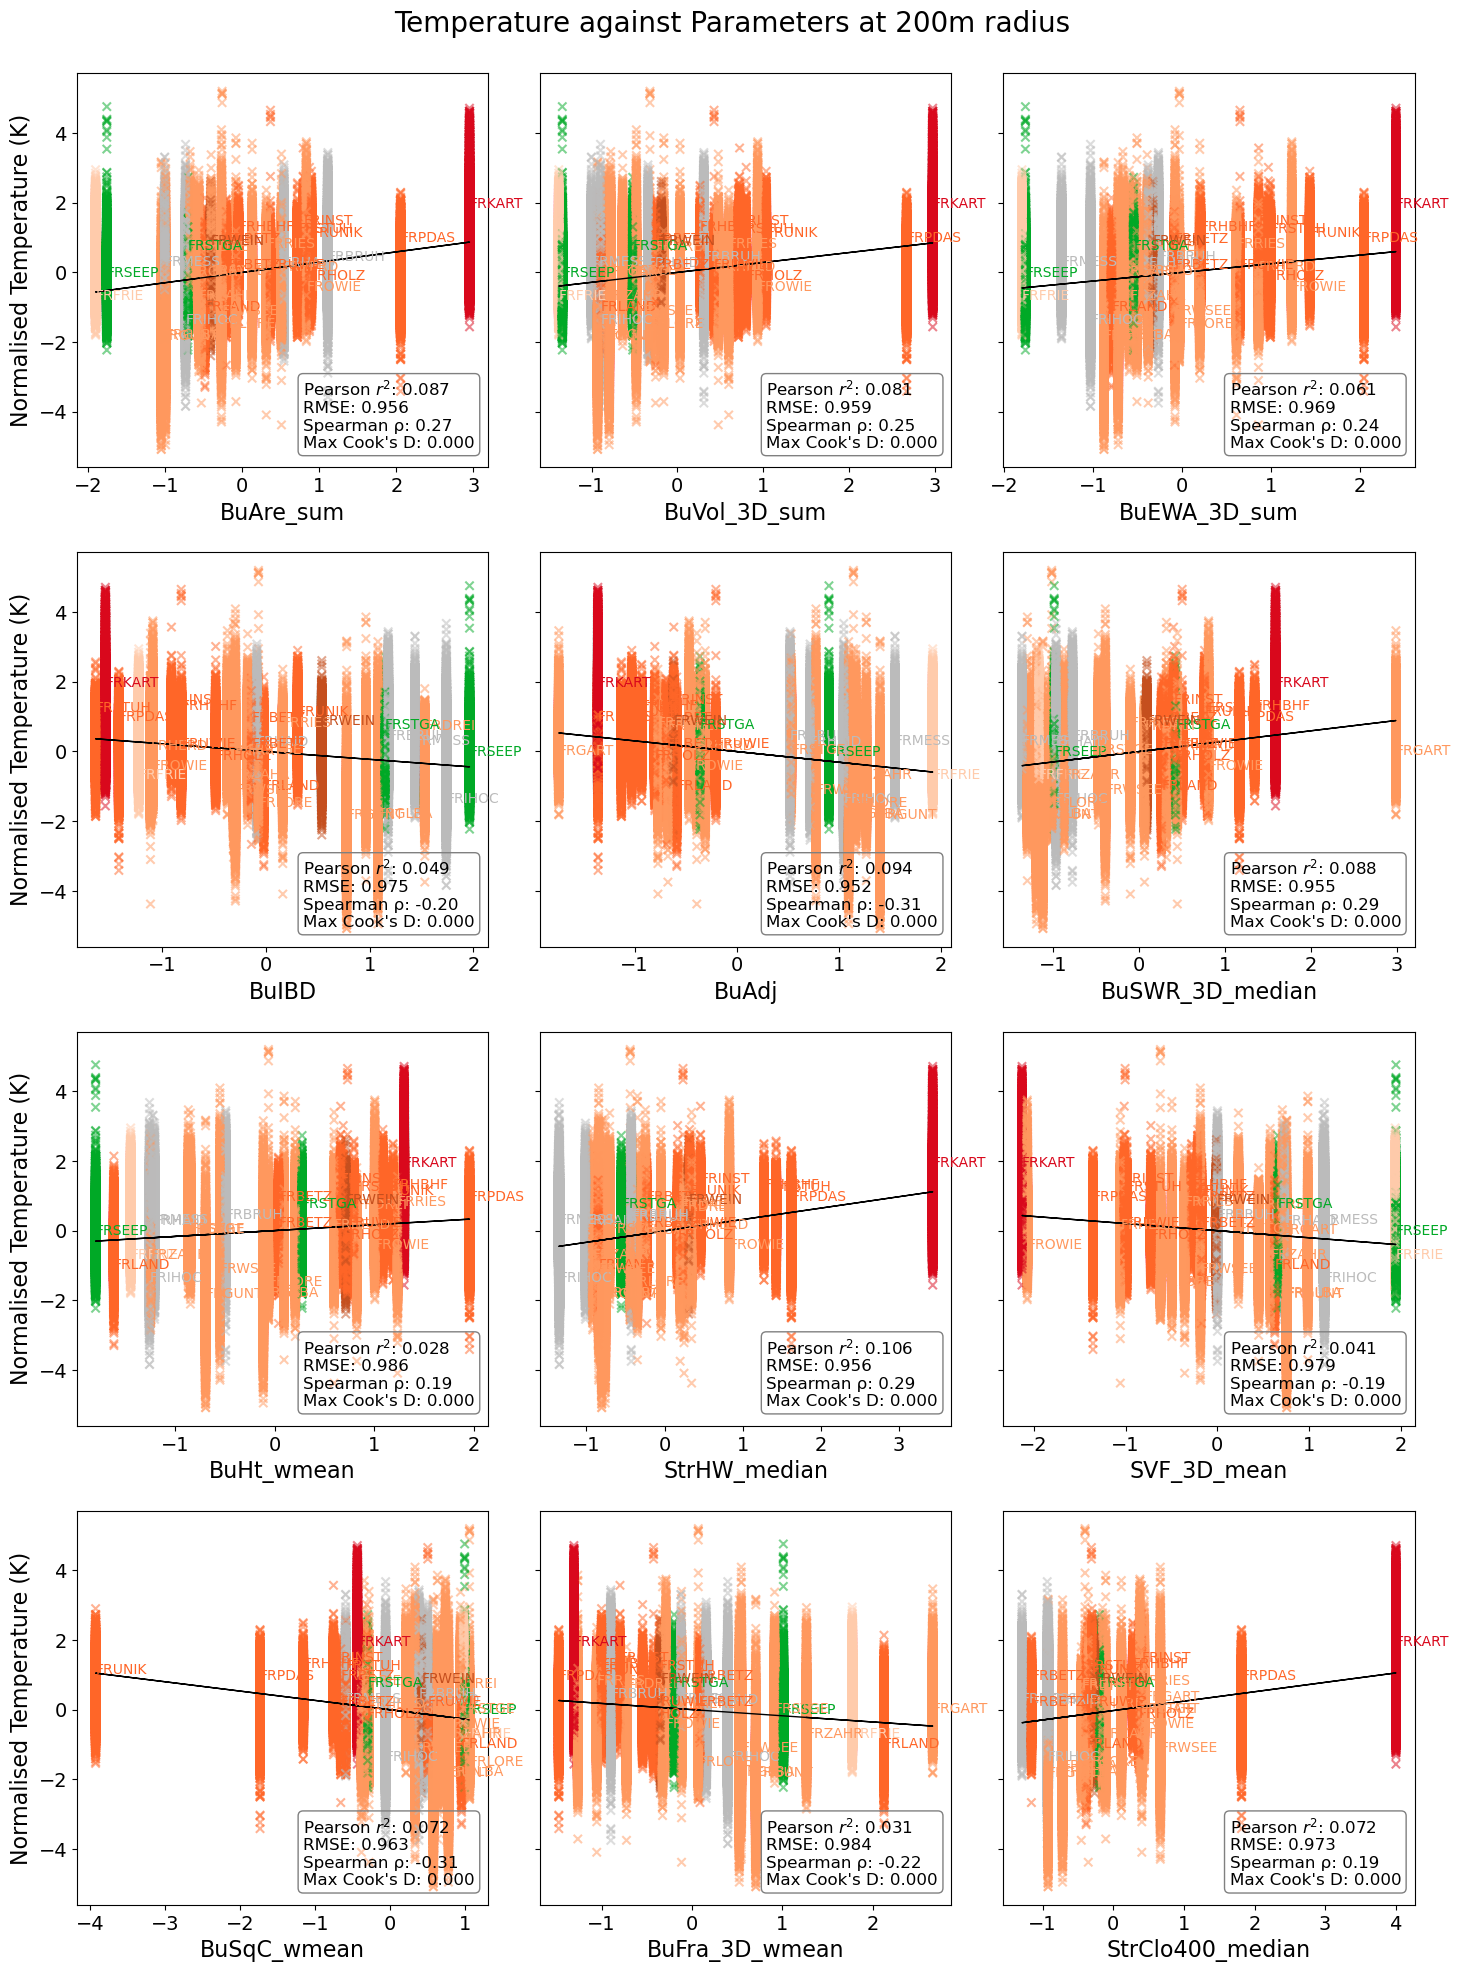

In [46]:
# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    plot2(ax, 200, params[i], all_year)
    ax.tick_params(axis='both', which='major', labelsize=14)

    if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
        ax.set_ylabel("")  # Remove y-axis label
        ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
        
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('/Users/lisawink/Documents/paper1/figures/all_year_temp_vs_params_200m_new.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/all_year_temp_vs_params_200m_new.pdf')
plt.show()

# HIWN

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/skle

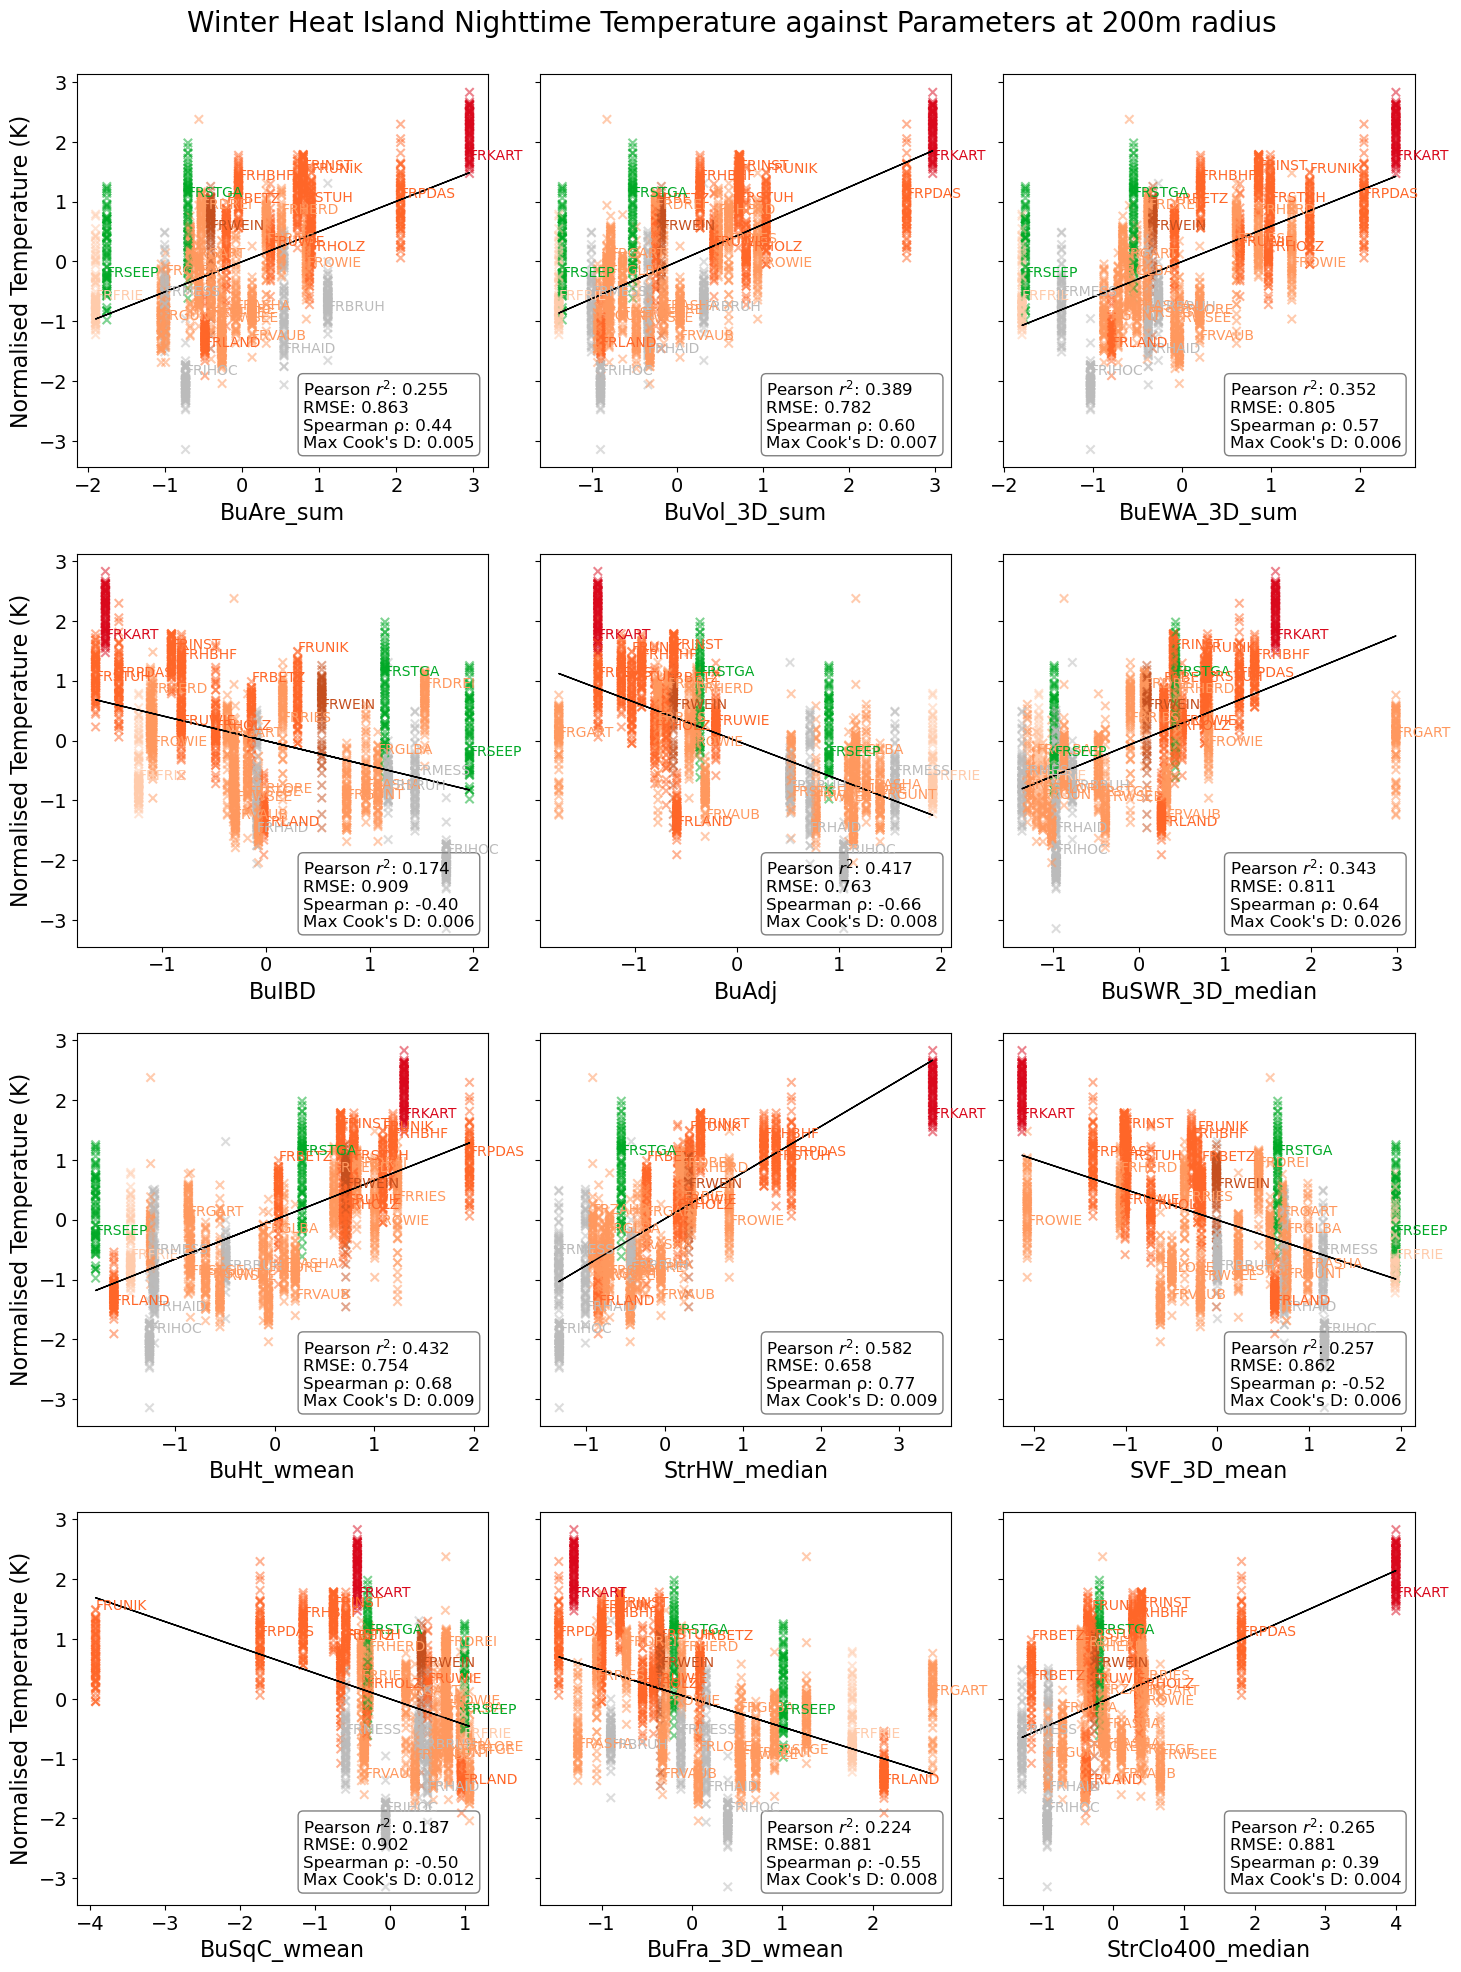

In [45]:
# make 3 by 4 plot with the following parameters
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuSqC_wmean','BuFra_3D_wmean', 'StrClo400_median']

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
fig.suptitle('Winter Heat Island Nighttime Temperature against Parameters at 200m radius', fontsize=20, y=0.99)
#fig.subplots_adjust(wspace=0.1)
for i, ax in enumerate(axs.flat):
    plot2(ax, 200, params[i], hiwn.values.flatten())
    ax.tick_params(axis='both', which='major', labelsize=14)

    if i % 3 != 0:  # 1st column (index 0, 3, 6, ...) keeps labels
        ax.set_ylabel("")  # Remove y-axis label
        ax.yaxis.set_ticklabels([])  # Remove y-axis ticks
        
plt.tight_layout(pad = 2, w_pad=0.01)
plt.savefig('/Users/lisawink/Documents/paper1/figures/hiwn_vs_params_200m_new.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/hiwn_vs_params_200m_new.pdf')
plt.show()

In [79]:
var = 'BuSWR_median'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

0.5892265769408851
0.9788288432535197


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


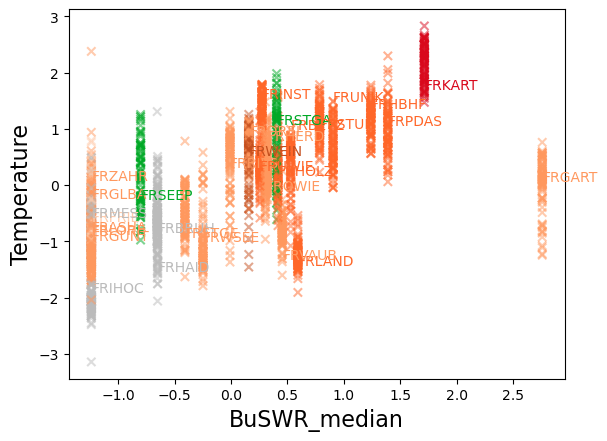

In [81]:
plot(radius, var, time)

In [82]:
var = 'BuSWR_mean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

0.572600862887972
0.9819424838505366


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [49]:
var = 'BuSWR_3D_mean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)

0.579893668745885


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [83]:
var = 'BuHt_mean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

0.625088269227222
0.9887713684643841


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [84]:
var = 'BuHt_median'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

0.5903519881589643
0.9930500078769833


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [85]:
var = 'StrHW_mean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

0.7664067818635074
0.986487010697122


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [86]:
var = 'BuCCo_wmean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.4479973265818521
0.9952394116896537


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [87]:
var = 'BuCCo_mode'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.47315628055205516
0.9965288270049337


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [88]:
var = 'BuHem_3D_mode'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.018784747290471047
0.996520967339087


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


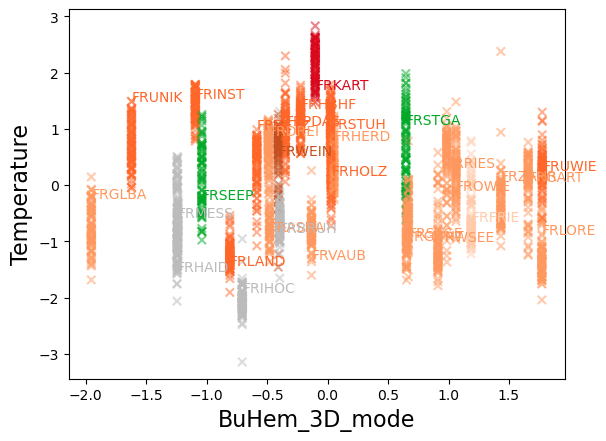

In [74]:
plot(radius, var, time)

In [89]:
var = 'BuFra_3D_wmedian'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.5749352277776886
0.9933610277745201


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [90]:
var = 'BuFra_3D_mode'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.48268649523376095
0.9891178533481498


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [91]:
var = 'BuFra_mode'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)
print(1-cooks_d)

-0.2720538363419177
0.9946250469347202


/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


In [ ]:
var = 'StrHW_mean'
radius=200
time = hiwn.values.flatten()
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)
print(spearman_corr)

In [ ]:
BuCCo_wmean

In [ ]:
data, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, y_pred = stats_multiple_times(radius, var, time)

In [56]:
plot(500,'StrHW_median',hiwn)

TypeError: plot() missing 1 required positional argument: 'time'

In [55]:
plot(30,'StrHW_median',hiwn)

TypeError: plot() missing 1 required positional argument: 'time'

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/lisawink/.conda/envs/py312

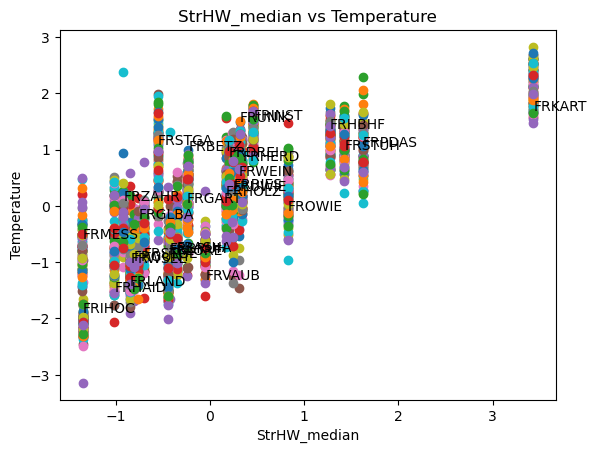

In [54]:
plot(200,'StrHW_median',hiwn)

/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1137: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1142: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/sklearn/utils/extmath.py:1162: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count
/Users/lisawink/.conda/envs/py312_uscuni_buildingfootprints/lib/python3.12/site-packages/matplotlib/text.py:1463: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y = float(self.convert_yunits(y))
/Users/lisawink/.conda/envs/py312

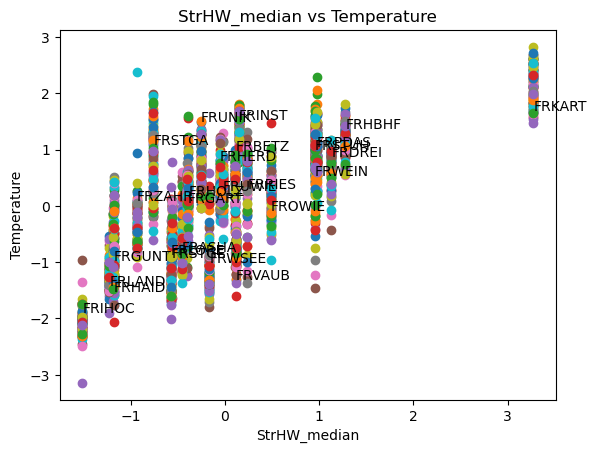

In [55]:
plot(100,'StrHW_median',hiwn)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


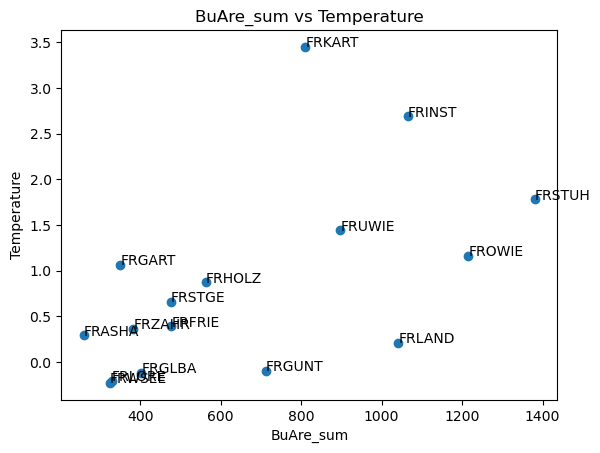

In [14]:
plot(30,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


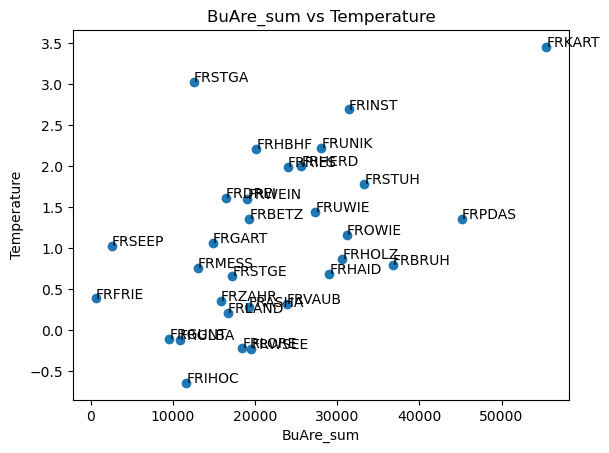

In [15]:
plot(180,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


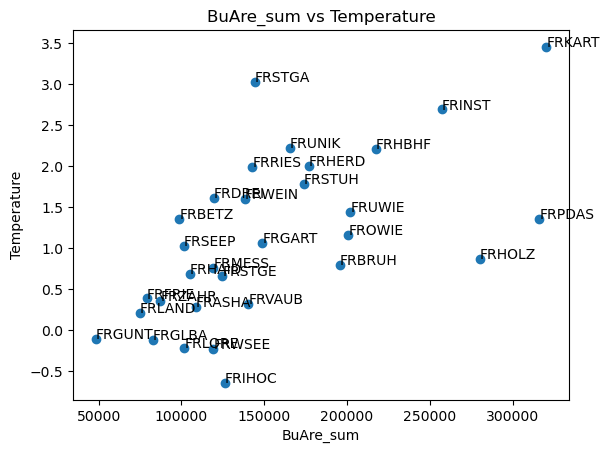

In [18]:
plot(500,'BuAre_sum')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


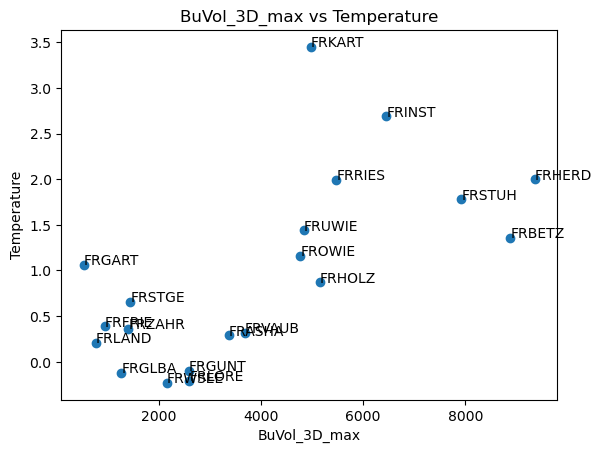

In [19]:
plot(40,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


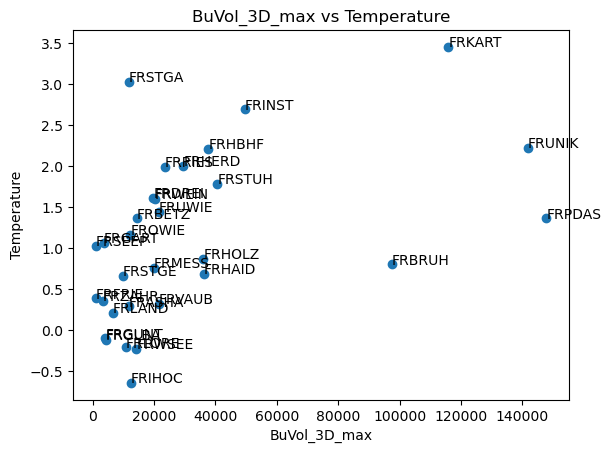

In [20]:
plot(160,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


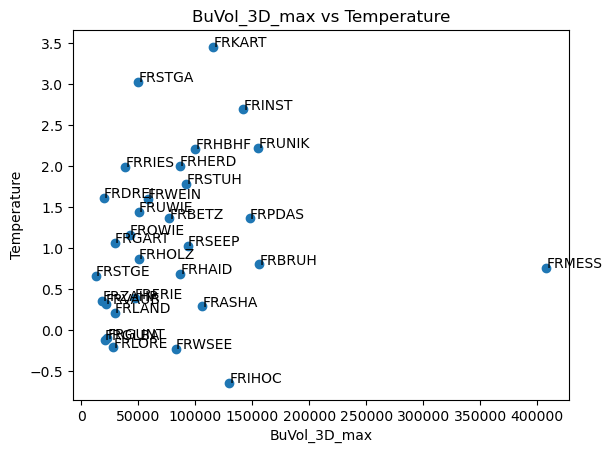

In [21]:
plot(400,'BuVol_3D_max')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


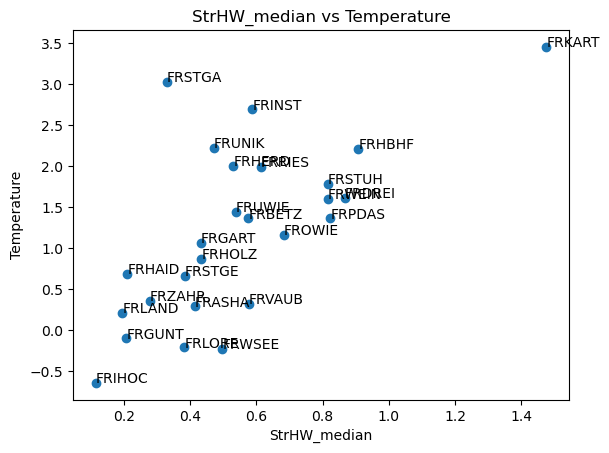

In [27]:
plot(100,'StrHW_median')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


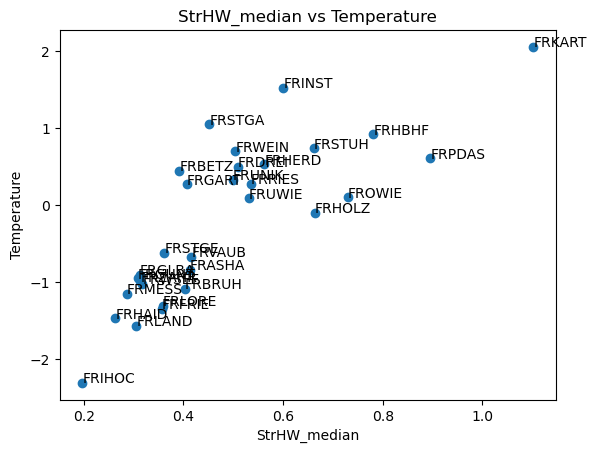

In [8]:
plot(250,'StrHW_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2022310589.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


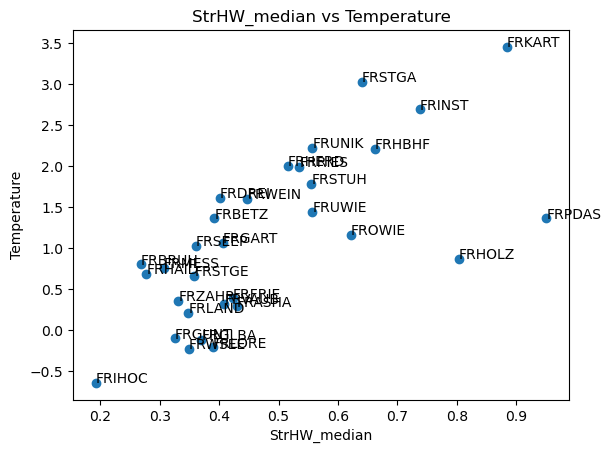

In [23]:
plot(500,'StrHW_median')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


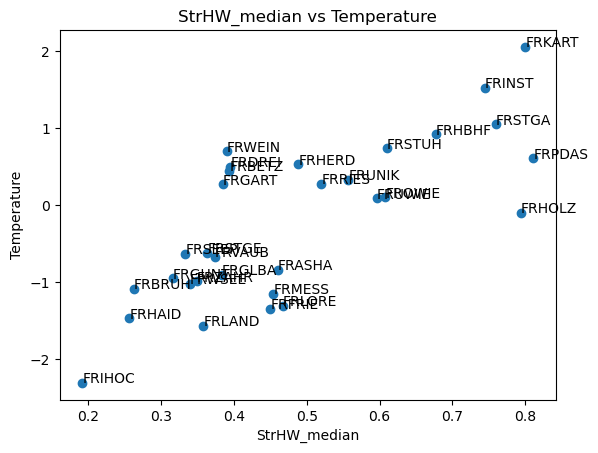

In [7]:
plot(750,'StrHW_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


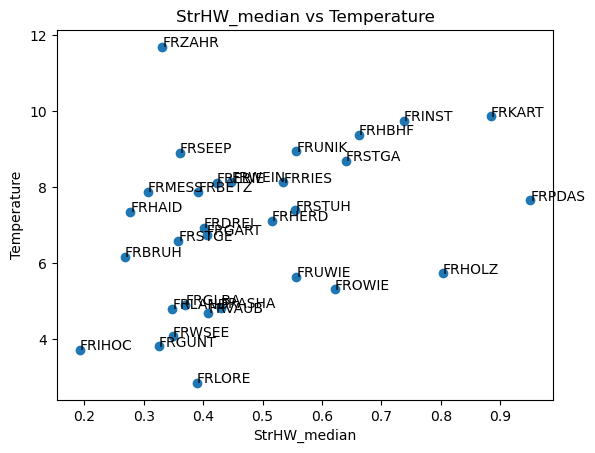

In [29]:
plot(500,'StrHW_median','2022-12-20 03:00:00+00:00')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


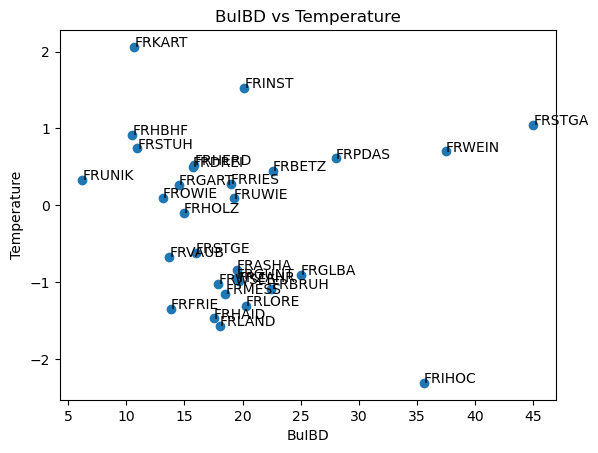

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


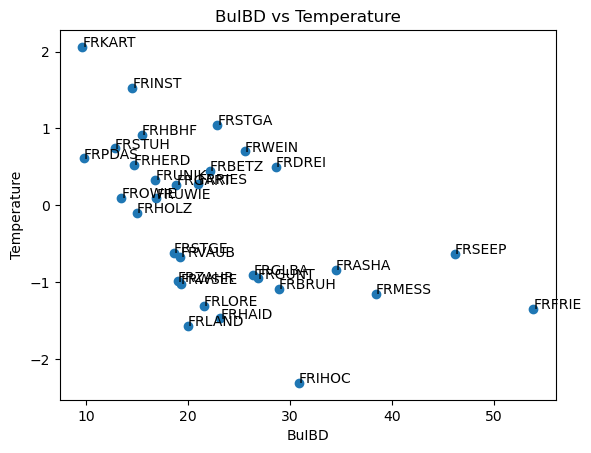

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


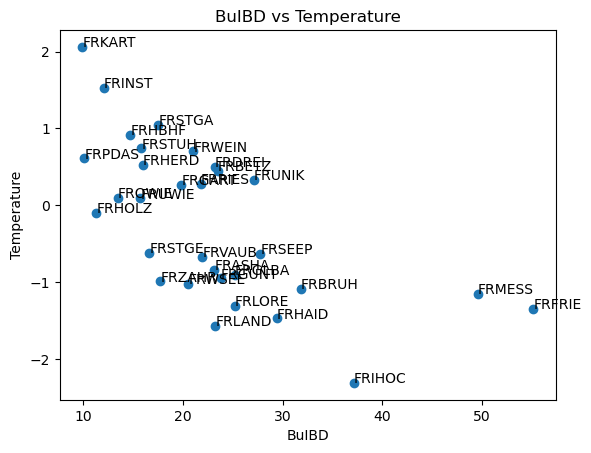

In [14]:
plot(100,'BuIBD',time)
plot(250,'BuIBD',time)
plot(400,'BuIBD',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


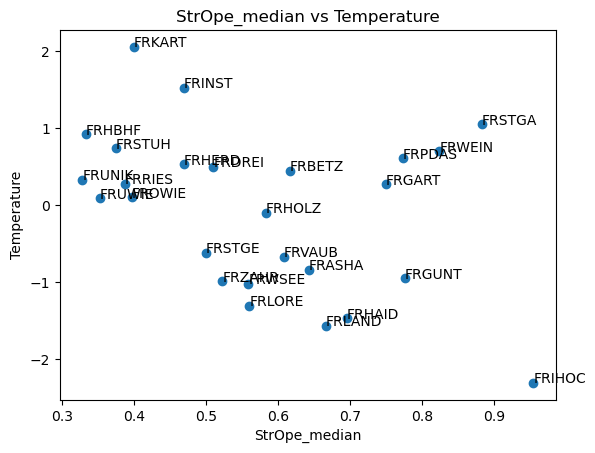

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


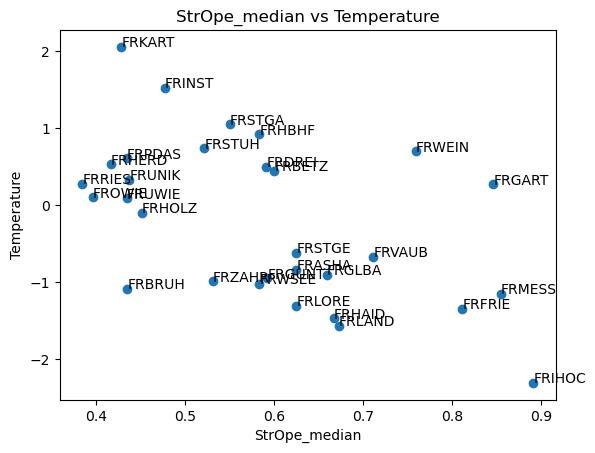

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


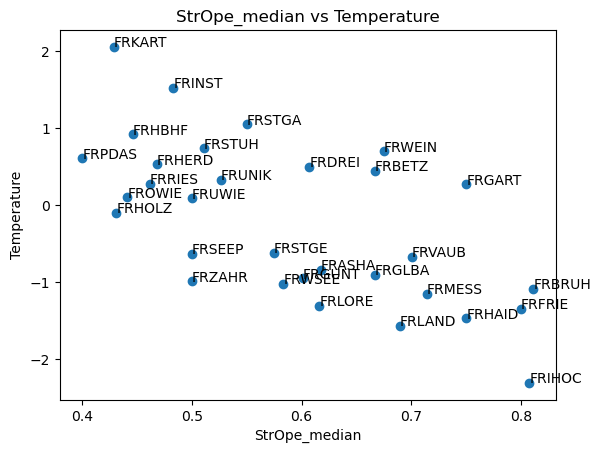

In [10]:
plot(100,'StrOpe_median',time)
plot(250,'StrOpe_median',time)
plot(400,'StrOpe_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


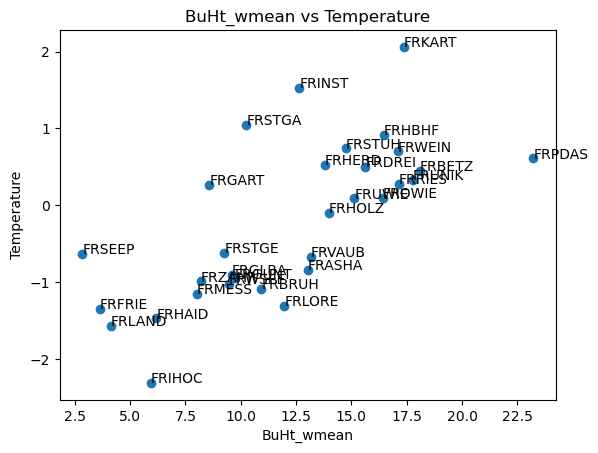

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


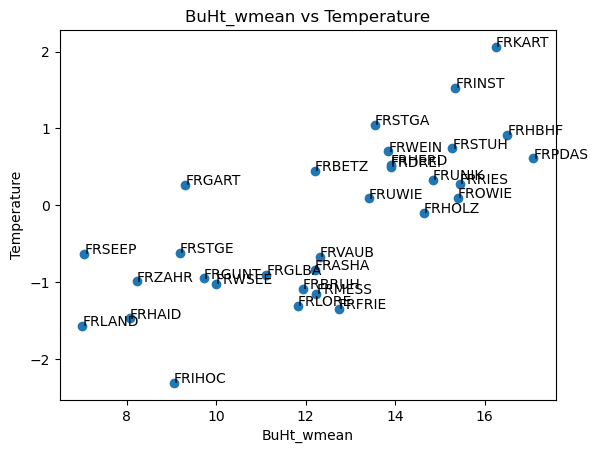

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


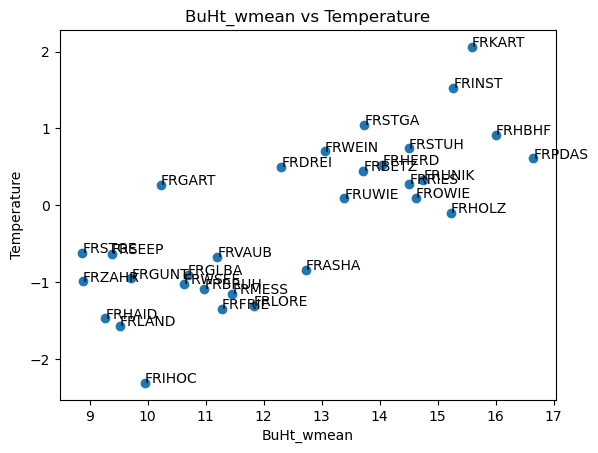

In [11]:
plot(100,'BuHt_wmean',time)
plot(250,'BuHt_wmean',time)
plot(400,'BuHt_wmean',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


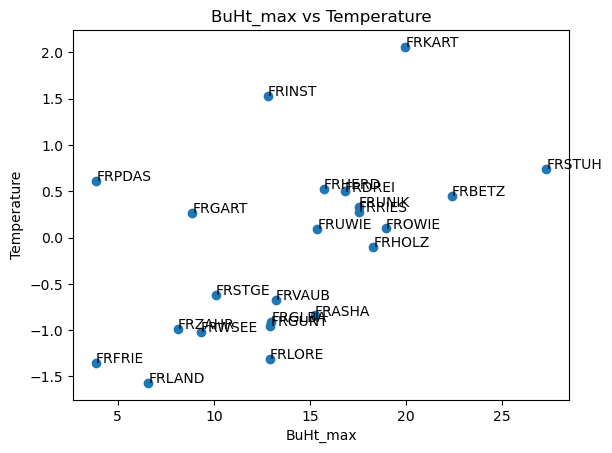

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


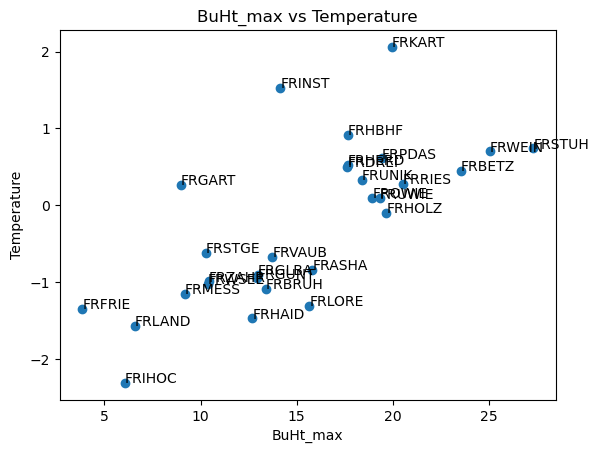

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


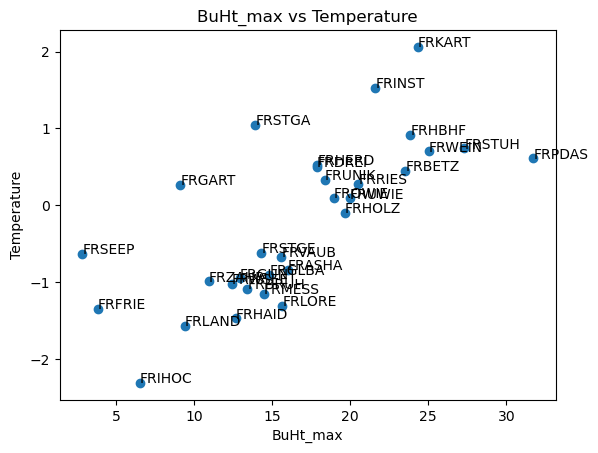

In [13]:
plot(50,'BuHt_max',time)
plot(80,'BuHt_max',time)
plot(100,'BuHt_max',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


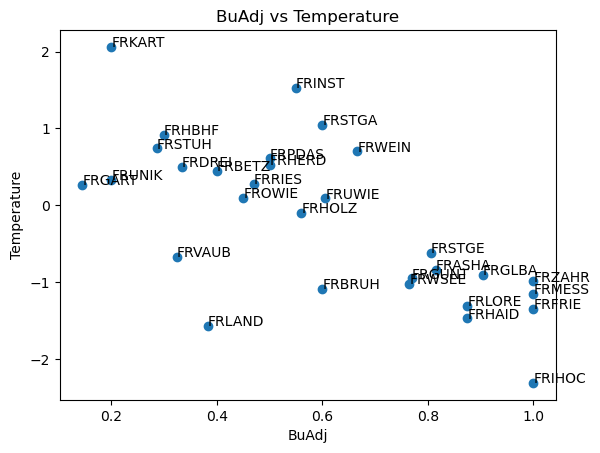

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


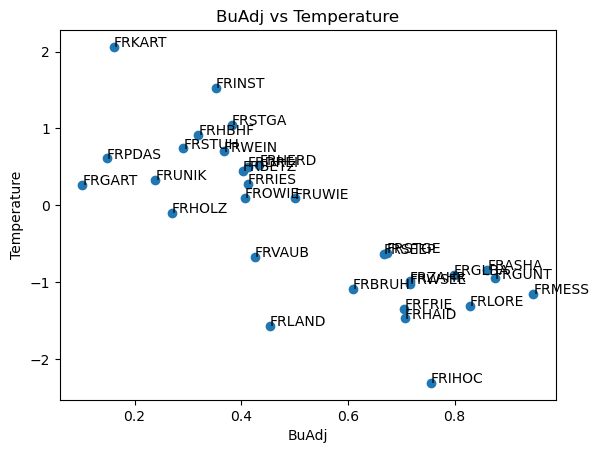

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_79940/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


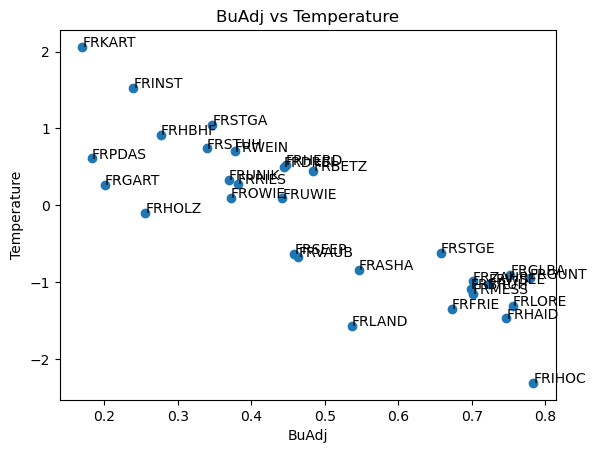

In [15]:
plot(100,'BuAdj',time)
plot(250,'BuAdj',time)
plot(400,'BuAdj',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


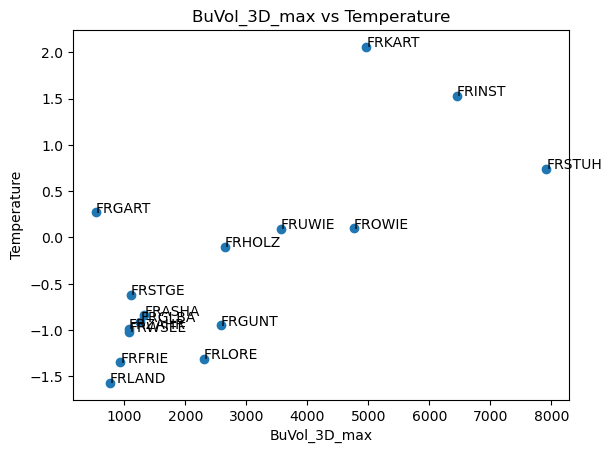

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


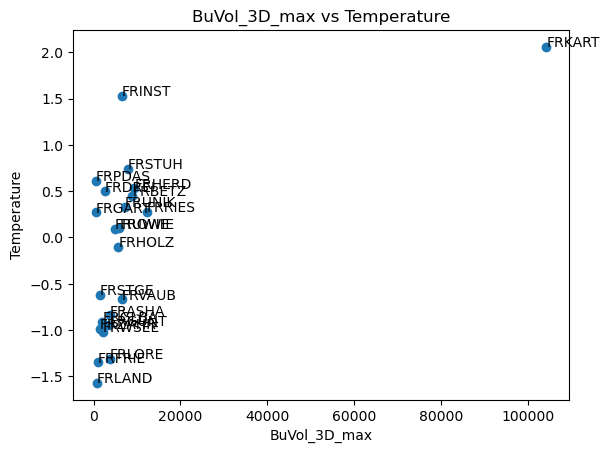

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


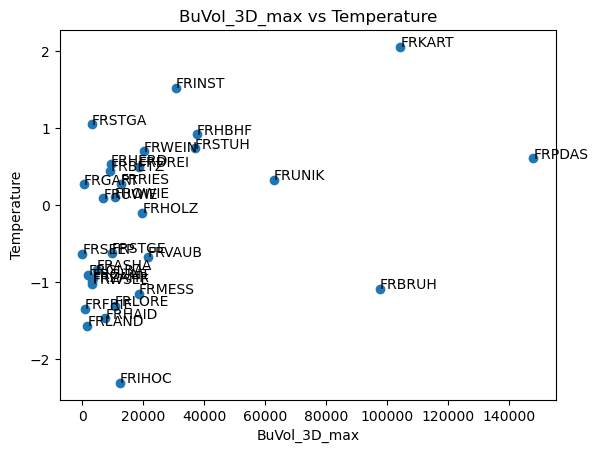

In [17]:
plot(30,'BuVol_3D_max',time)
plot(50,'BuVol_3D_max',time)
plot(100,'BuVol_3D_max',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


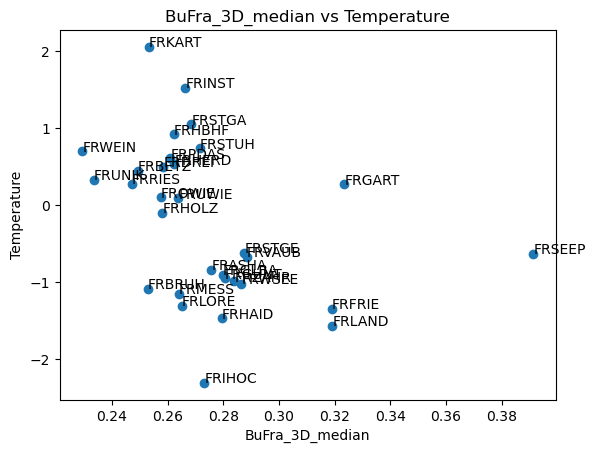

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


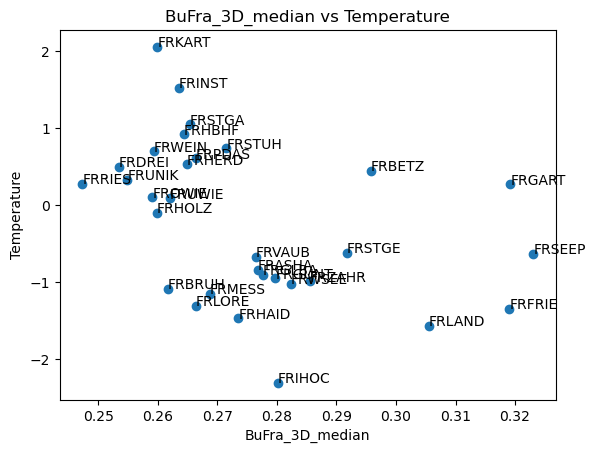

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


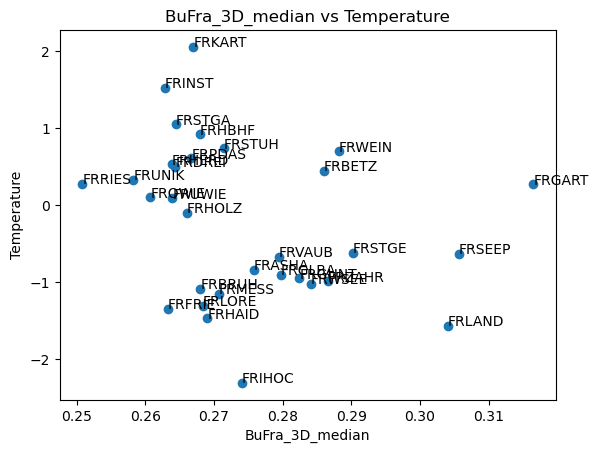

In [23]:
plot(100,'BuFra_3D_median',time)
plot(180,'BuFra_3D_median',time)
plot(300,'BuFra_3D_median',time)

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


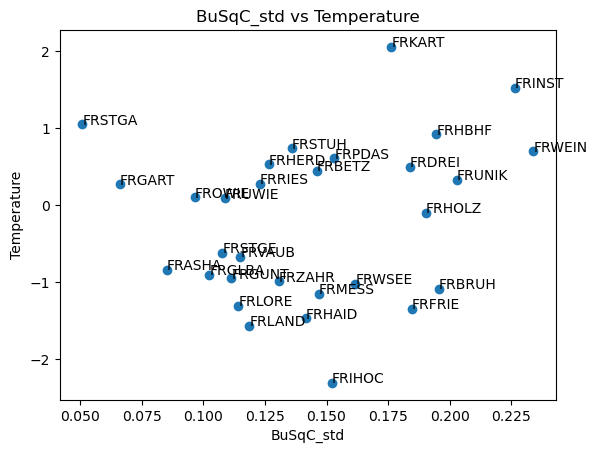

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


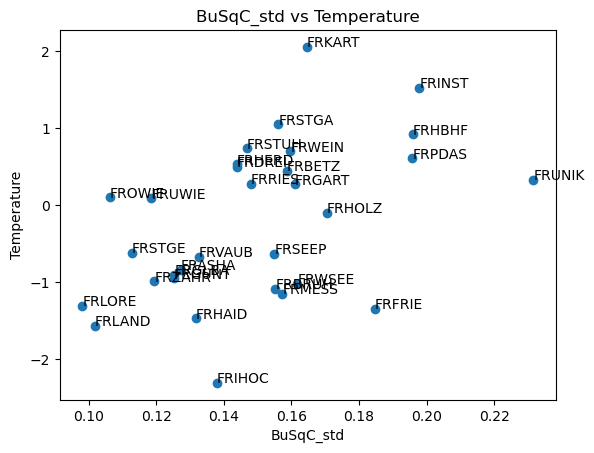

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_81870/4285885498.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


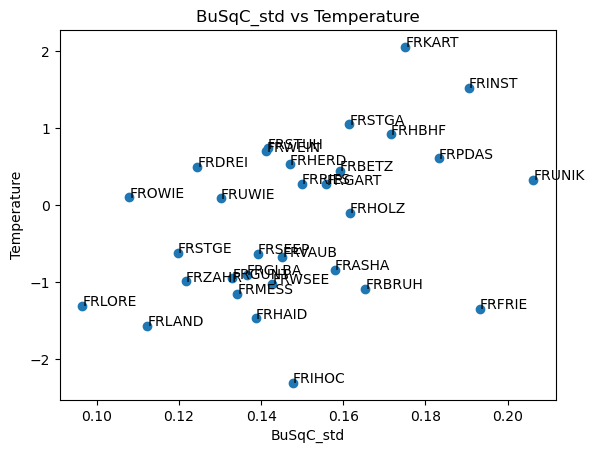

In [22]:
plot(100,'BuSqC_std',time)
plot(180,'BuSqC_std',time)
plot(300,'BuSqC_std',time)

In [11]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_70.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2079826693.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


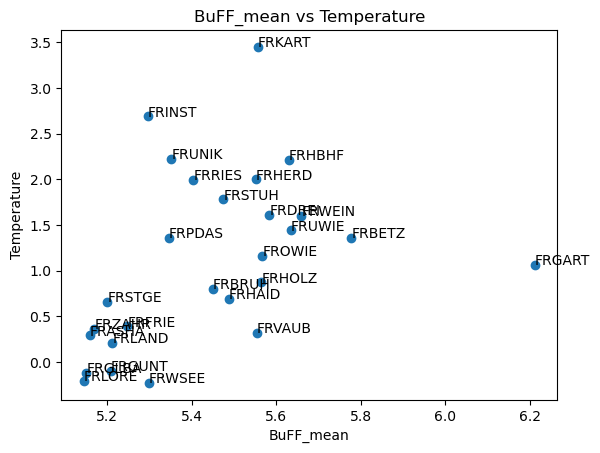

In [12]:
var = 'BuFF_mean'

plt.scatter(vars[var], vars[time])
plt.xlabel(var)
plt.ylabel('Temperature')
plt.title(var+' vs Temperature')

for i, txt in enumerate(vars.index):
    plt.annotate(txt, (vars[var][i], vars[time][i]))


plt.show()

In [8]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_160.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')

/var/folders/_c/80m5cqnd3ml3s2h2xdwdq9f40000gp/T/ipykernel_66406/2079826693.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  plt.annotate(txt, (vars[var][i], vars[time][i]))


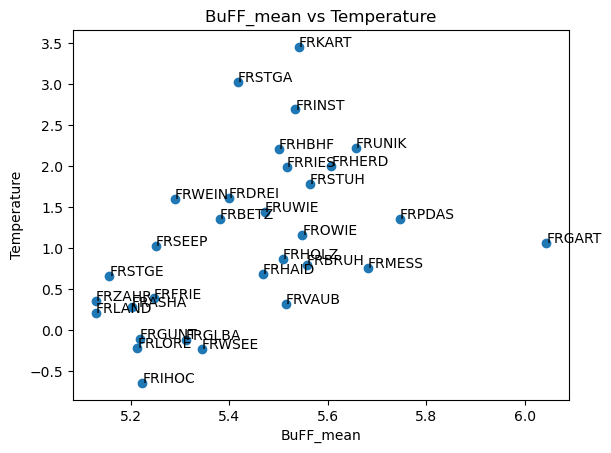

In [10]:
var = 'BuFF_mean'

plt.scatter(vars[var], vars[time])
plt.xlabel(var)
plt.ylabel('Temperature')
plt.title(var+' vs Temperature')

for i, txt in enumerate(vars.index):
    plt.annotate(txt, (vars[var][i], vars[time][i]))


plt.show()

In [ ]:
vars = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_30.parquet')
vars.index = vars['station_id']
to_remove = ['station_id','station_no','station_name','station_long_name','station_type','station_lat','station_lon','station_elevation','mounting_structure','sky_view_factor','dominant_land_use','local_climate_zone','urban_atlas_class','urban_atlas_code','geometry','SVF']
vars = vars.drop(to_remove, axis=1)
vars = vars.merge(temp[time], left_on='station_id', right_on='station_id',how='inner')